# Урок 5. Сегментация изображений

Необходимо подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples для обучения модели на сегментацию губ

Обучить модель на выбор из segmentation_models_pytorch

У кого нет возможности работать через каггл (нет верификации), то можете данные взять по ссылке: https://disk.yandex.ru/d/nWMoBVgvWYcI7g


In [1]:
from torch import nn 
from torch import optim
import torchvision.transforms as transforms
import torch, torchvision
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import numpy as np
import pandas as pd
import cv2
import os
from matplotlib import pyplot as plt
import segmentation_models_pytorch as smp

from sklearn.model_selection import train_test_split

In [2]:
import albumentations as A

In [3]:
df = pd.read_csv('set-lipstick-original/list.csv')
df.head(5)

filename  width  height class  xmin  ymin  xmax  ymax  \
0  image00000001.jpg   1280     720  Lips   661   394   776   444   
1  image00000002.jpg   1280     720  Lips   557   336   682   392   
2  image00000003.jpg   1280     720  Lips   553   369   684   427   
3  image00000004.jpg   1280     720  Lips   555   351   681   408   
4  image00000005.jpg   1280     720  Lips   555   351   680   407   

               mask  
0  mask00000001.png  
1  mask00000002.png  
2  mask00000003.png  
3  mask00000004.png  
4  mask00000005.png

In [4]:
IMAGES_PATH = 'set-lipstick-original/720p/'
MASKS_PATH = 'set-lipstick-original/mask'

In [5]:
imgs_set = set(os.listdir(IMAGES_PATH))
masks_set = set(os.listdir(MASKS_PATH))

imgs_set = set(''.join(filter(lambda x: x.isdigit(), i)) for i in imgs_set)
masks_set = set(''.join(filter(lambda x: x.isdigit(), i)) for i in masks_set)

In [6]:
len(imgs_set.difference(masks_set)), len(masks_set.difference(imgs_set))

(54, 0)

Удаляем изображения без масок

In [7]:
not_mask = imgs_set.difference(masks_set)

not_mask = [f'image{i}.jpg' for i in not_mask]

df = df.loc[~df['filename'].isin(not_mask)]
df.reset_index(drop=True, inplace=True)

In [8]:
df.head()

filename  width  height class  xmin  ymin  xmax  ymax  \
0  image00000001.jpg   1280     720  Lips   661   394   776   444   
1  image00000002.jpg   1280     720  Lips   557   336   682   392   
2  image00000003.jpg   1280     720  Lips   553   369   684   427   
3  image00000004.jpg   1280     720  Lips   555   351   681   408   
4  image00000005.jpg   1280     720  Lips   555   351   680   407   

               mask  
0  mask00000001.png  
1  mask00000002.png  
2  mask00000003.png  
3  mask00000004.png  
4  mask00000005.png

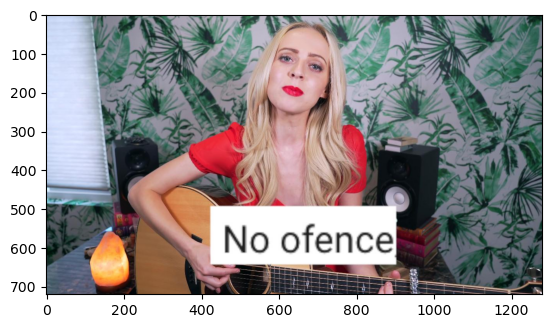

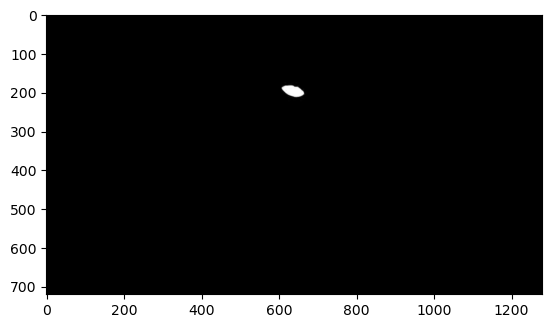

In [9]:
idx = np.random.randint(len(df))

sample = df.iloc[idx]

img_path = os.path.join(IMAGES_PATH, sample['filename'])
mask_path = os.path.join(MASKS_PATH, sample['mask'])

img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_RGB2BGR)
mask = cv2.imread(mask_path)[:, :, 1]

plt.imshow(img)
plt.show()

plt.imshow(mask, cmap='gray')
plt.show()

In [10]:
class LipsSegmentationDataset(Dataset):
    
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    
    def __getitem__(self, idx):
        data = self.df.iloc[idx]
        
        img_path = os.path.join(IMAGES_PATH, data['filename'])
        mask_path = os.path.join(MASKS_PATH, data['mask'])
        
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_RGB2BGR)
        mask = cv2.imread(mask_path)[:, :, 1]
        
        if self.transform:
            img, mask = self.transform(img, mask)
            
        return img, mask
    
    def __len__(self):
        return len(self.df)

In [11]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [12]:
transform = A.Compose([
    A.RandomBrightnessContrast(),
    A.HorizontalFlip(),
    A.Rotate(limit=90, border_mode=0, value=0),
    A.GaussNoise(var_limit=(50.0, 100.0)),
    A.ChannelShuffle(),
    A.OpticalDistortion(), 
    A.GridDistortion(distort_limit=(-0.15, 0.15), border_mode=0, value=0), 
    A.Transpose()
])


to_tensor = transforms.ToTensor()

def tensor_img_mask(img, mask, shape=(256, 256)):
    img, mask = cv2.resize(img, shape), cv2.resize(mask, shape)
    return to_tensor(img), to_tensor(mask)

def transform_img_mask(img, mask, shape=(256, 256)):
    img, mask = cv2.resize(img, shape), cv2.resize(mask, shape)
    transformed = transform(image=img, mask=mask)
    img, mask = transformed['image'], transformed['mask']
    img, mask = to_tensor(img), to_tensor(mask)
    return img, mask

In [13]:
train_dataset = LipsSegmentationDataset(train_df, transform=transform_img_mask)
test_dataset = LipsSegmentationDataset(test_df, transform=tensor_img_mask)

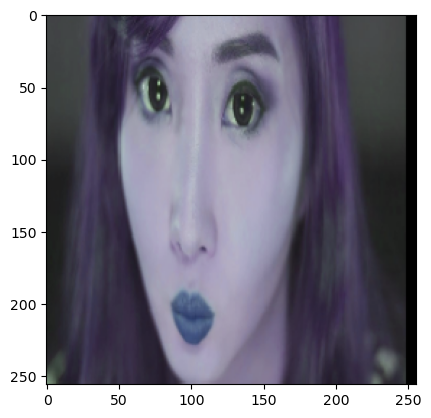

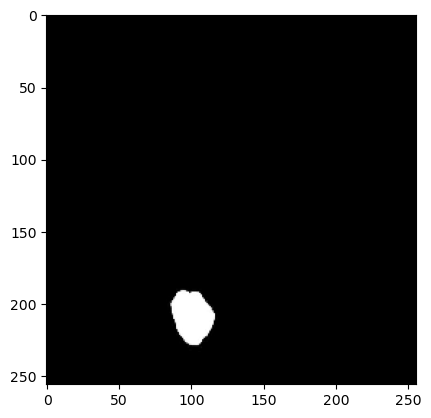

In [14]:
idx = int(np.random.random() * len(train_dataset))

img, mask = train_dataset[idx]

plt.imshow(img.permute(1, 2, 0))
plt.show()

plt.imshow(mask.permute(1, 2, 0), cmap='gray')
plt.show()

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [16]:
segmodel = smp.Unet('resnet34', classes=1, activation='sigmoid').to(device)

In [17]:
summary(segmodel, input_size=(3, 256, 256), batch_size=8, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 64, 128, 128]           9,408
       BatchNorm2d-2          [8, 64, 128, 128]             128
              ReLU-3          [8, 64, 128, 128]               0
         MaxPool2d-4            [8, 64, 64, 64]               0
            Conv2d-5            [8, 64, 64, 64]          36,864
       BatchNorm2d-6            [8, 64, 64, 64]             128
              ReLU-7            [8, 64, 64, 64]               0
            Conv2d-8            [8, 64, 64, 64]          36,864
       BatchNorm2d-9            [8, 64, 64, 64]             128
             ReLU-10            [8, 64, 64, 64]               0
       BasicBlock-11            [8, 64, 64, 64]               0
           Conv2d-12            [8, 64, 64, 64]          36,864
      BatchNorm2d-13            [8, 64, 64, 64]             128
             ReLU-14            [8, 64,

In [18]:
class DiceLoss(nn.Module):
    
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 1
        num = targets.size(0)
        probs = logits
        m1 = probs.reshape(num, -1)
        m2 = targets.reshape(num, -1)
        intersection = (m1 * m2)

        score = (2. * intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score = 1 - (score.sum() / num)
        return score

In [19]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=32, 
    shuffle=True, 
    num_workers=0
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=8, 
    shuffle=False, 
    num_workers=0
)

In [20]:
criterion = DiceLoss()
optimizer = torch.optim.Adam(segmodel.parameters(), lr=0.001)

In [21]:
import time


def draw_imgs(img, mask, pred_mask):
    
    fig, ax = plt.subplots(1, 3, figsize=(17, 5))

    ax[0].imshow(img.cpu().permute(1, 2, 0))
    ax[0].set_title('Image')

    ax[1].imshow(mask.cpu().permute(1, 2, 0), cmap='gray')
    ax[1].set_title('Mask')

    ax[2].imshow(pred_mask.detach().cpu().permute(1, 2, 0), cmap='gray')
    ax[2].set_title('Predicted Mask')

    plt.show()


def evaluate_model(model, loader, device, criterion):
    loss = 0.
    model.eval()
    with torch.no_grad():
        for data, label in loader:
            data, label = data.to(device), label.to(device)

            output = model(data)
            loss += criterion(output, label).item()
    
    val_loss = loss / len(loader)
    
    print(
        f'- val_loss: {val_loss:.4f}', 
        end='\n')
    
    idx = np.random.randint(len(data))
    draw_imgs(data[idx], label[idx], output[idx])
    
    model.train()
    return loss/len(loader)


def epoch_training(model, criterion, optimizer, train_set, device):
    
    running_loss = 0.0
    
    n_steps = len(train_set)
    steps_n_signs = len(str(n_steps))
    
    for i, data in enumerate(train_set):
        start_time = time.time()
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss = running_loss / (i + 1)
        
        step_duration = time.time() - start_time
        duration = step_duration * n_steps

        print(
            '\r' \
            f'step [{str(i + 1).zfill(steps_n_signs)}/{n_steps}] ' \
            f'- loss: {epoch_loss:.4f} ',
            end='', flush=True)
    
    return epoch_loss


def model_training(model, criterion, optimizer, epochs, device, train_set, valid_set=None):
    history = {
        'loss': []
    }
    if valid_set:
        history['val_loss'] = []
    
    for epoch in range(epochs):

        model.train()
        start_time = time.time()
        
        print(
            f'Epoch {epoch + 1}/{epochs}', 
            end='\n')
        
        epoch_loss = epoch_training(model, criterion, optimizer, train_set, device)
        
        duration = round(time.time() - start_time)
        
        if valid_set:
            val_loss = evaluate_model(model, valid_set, device, criterion)
            history['val_loss'].append(val_loss)
        
        history['loss'].append(epoch_loss)
        
        print(
            '\n' \
            f'duration: {duration}s ({round((duration/len(train_set)) * 1000)}ms/step)\n', 
            end='\n')

    print('Training is finished!')
    
    return history

Epoch 1/10
step [625/625] - loss: 0.3054 - val_loss: 0.1048


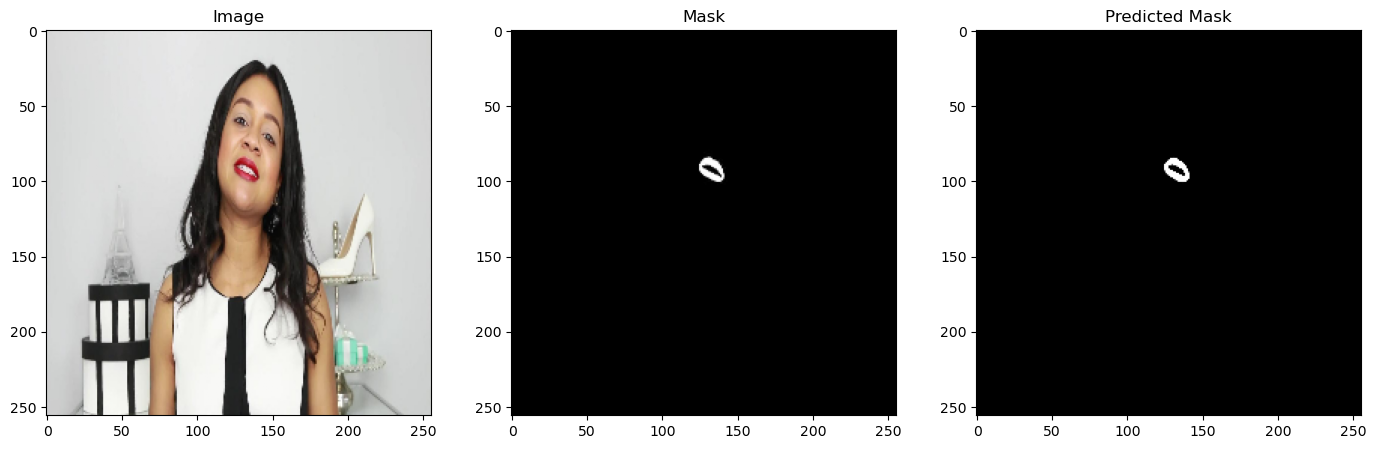


duration: 514s (822ms/step)

Epoch 2/10
step [625/625] - loss: 0.1426 - val_loss: 0.0779


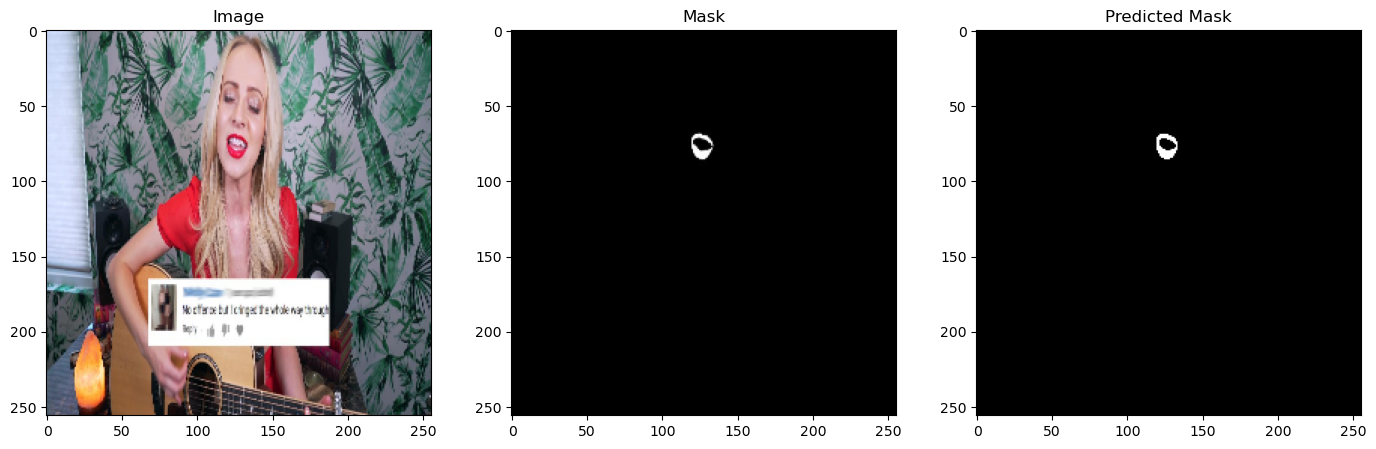


duration: 512s (819ms/step)

Epoch 3/10
step [625/625] - loss: 0.1277 - val_loss: 0.0841


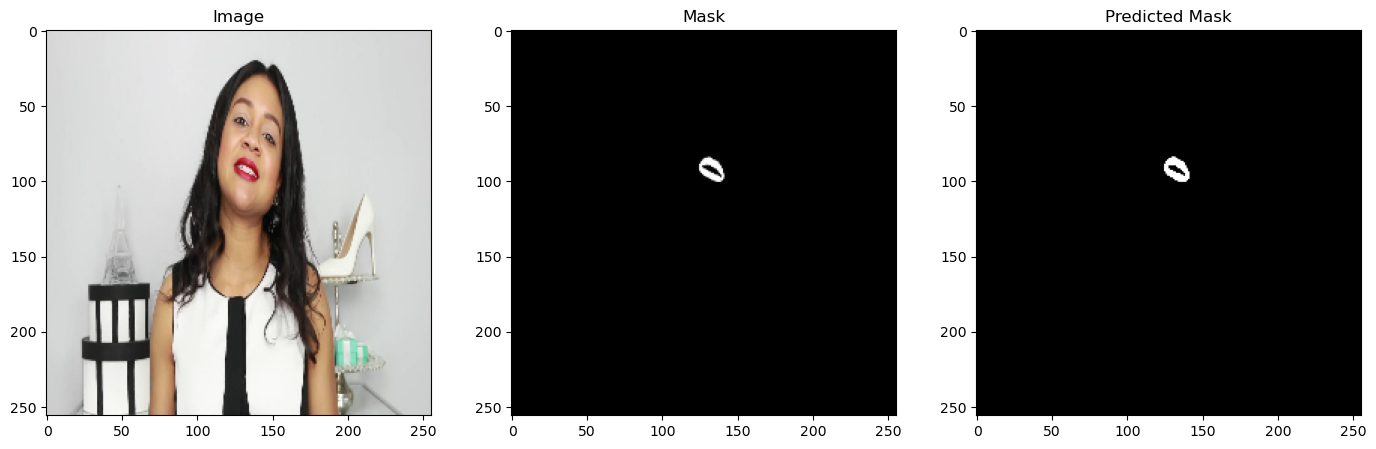


duration: 513s (821ms/step)

Epoch 4/10
step [625/625] - loss: 0.1279 - val_loss: 0.0723


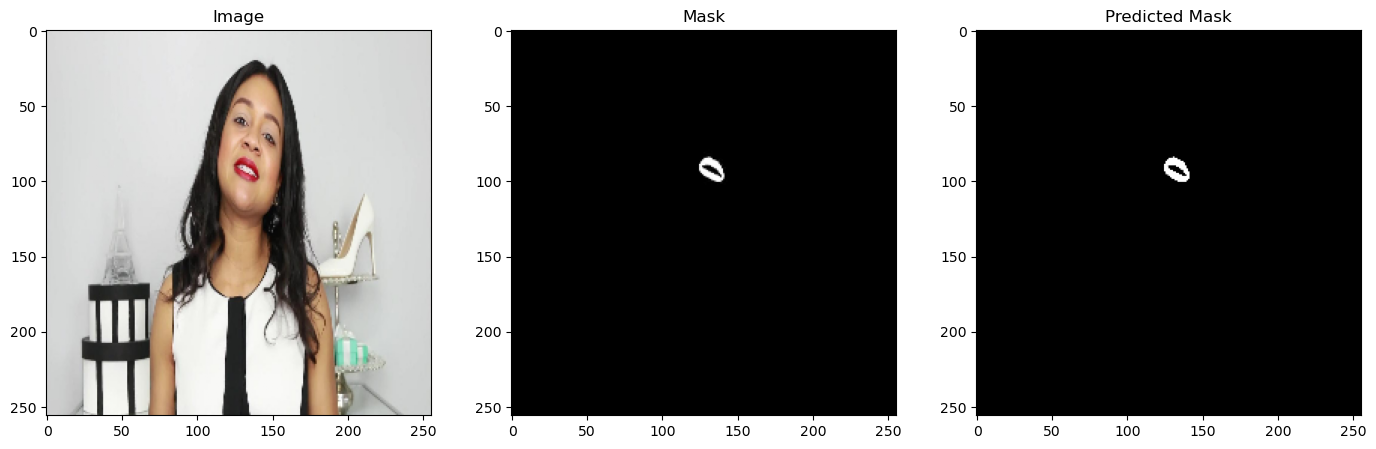


duration: 507s (811ms/step)

Epoch 5/10
step [625/625] - loss: 0.1295 - val_loss: 0.0720


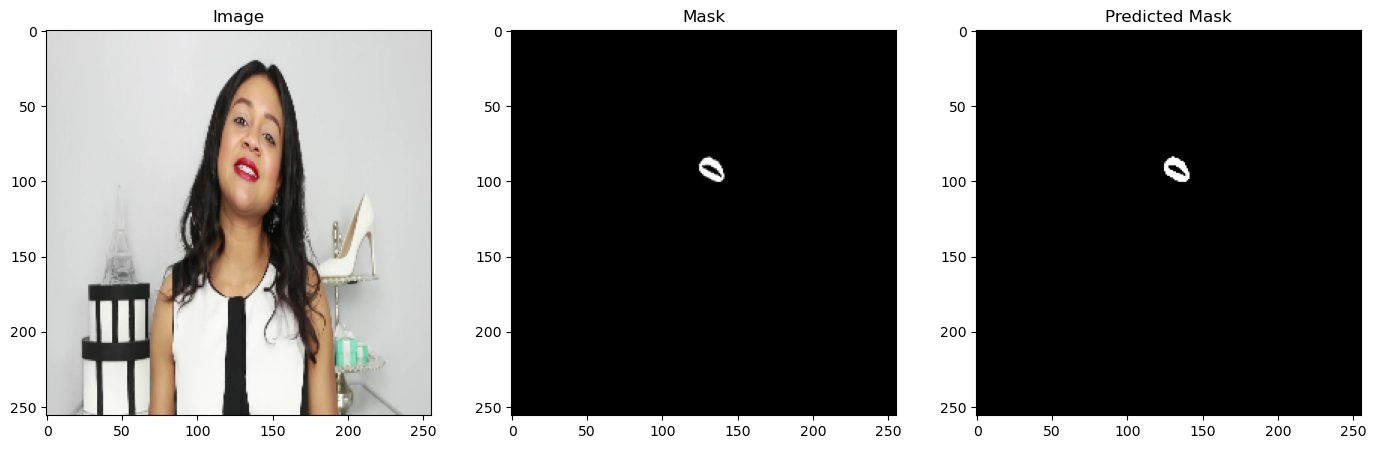


duration: 501s (802ms/step)

Epoch 6/10
step [625/625] - loss: 0.1204 - val_loss: 0.0781


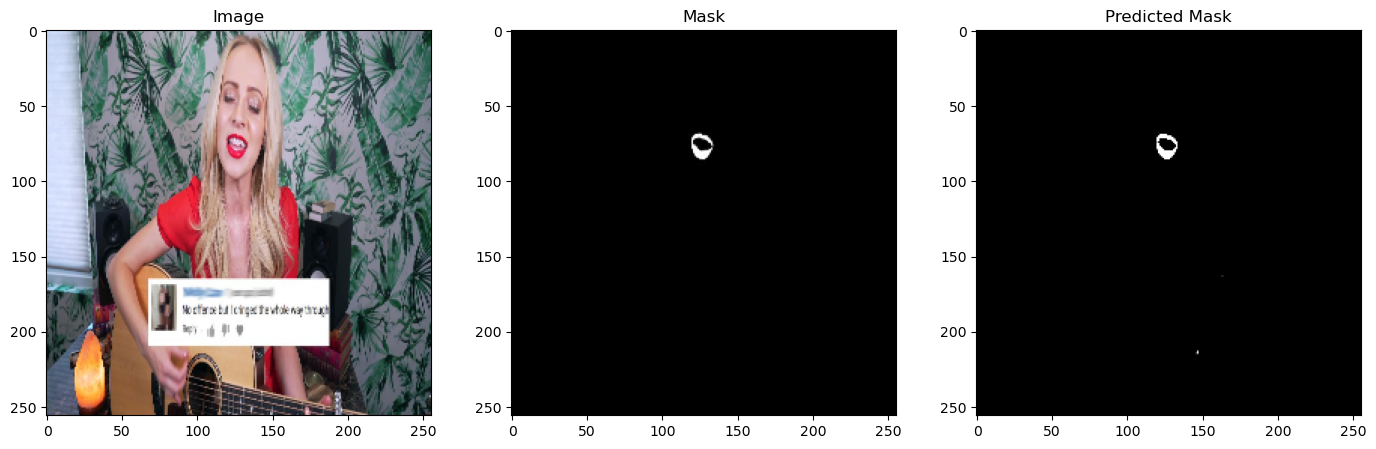


duration: 501s (802ms/step)

Epoch 7/10
step [625/625] - loss: 0.1162 - val_loss: 0.0655


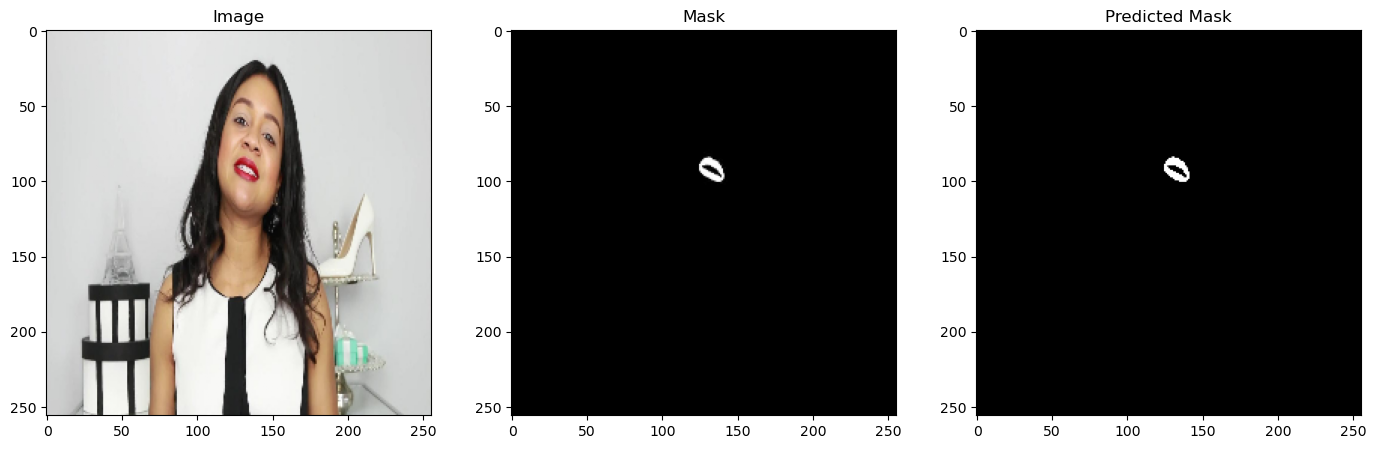


duration: 509s (814ms/step)

Epoch 8/10
step [625/625] - loss: 0.1175 - val_loss: 0.0690


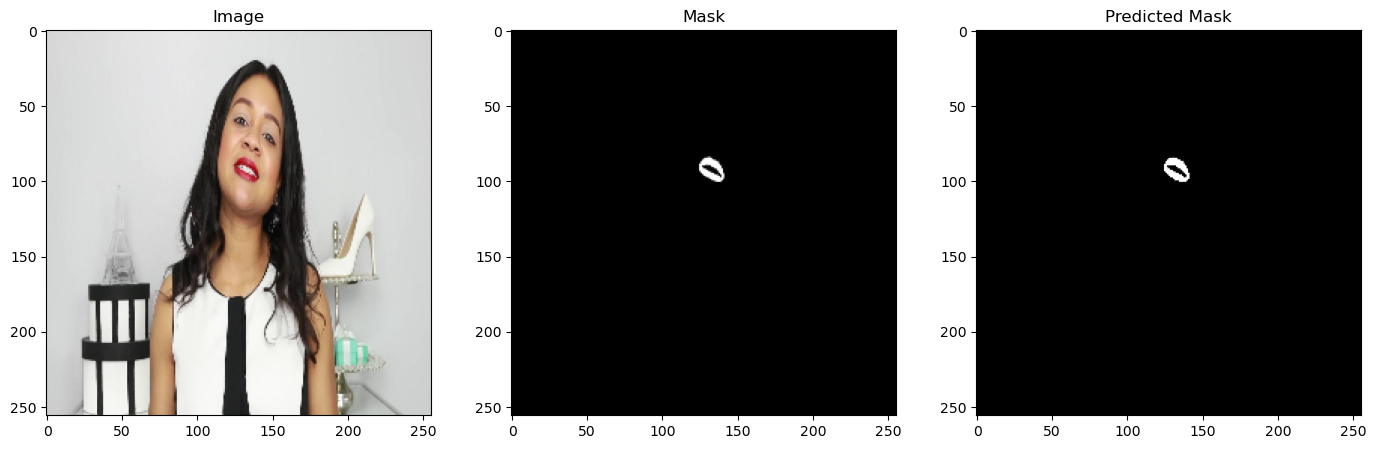


duration: 521s (834ms/step)

Epoch 9/10
step [625/625] - loss: 0.1182 - val_loss: 0.0650


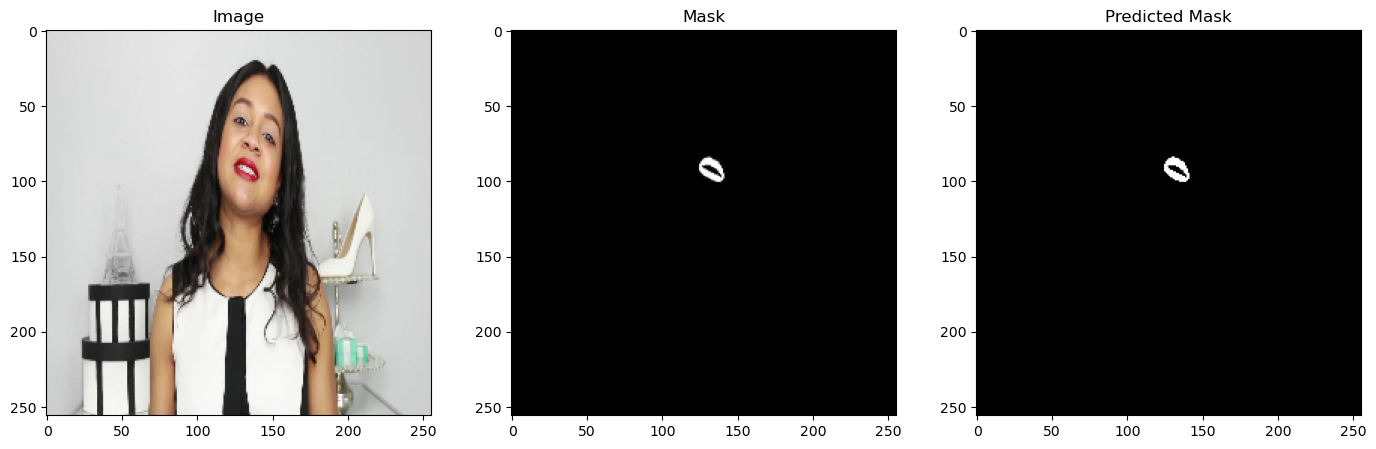


duration: 511s (818ms/step)

Epoch 10/10
step [625/625] - loss: 0.1146 - val_loss: 0.0680


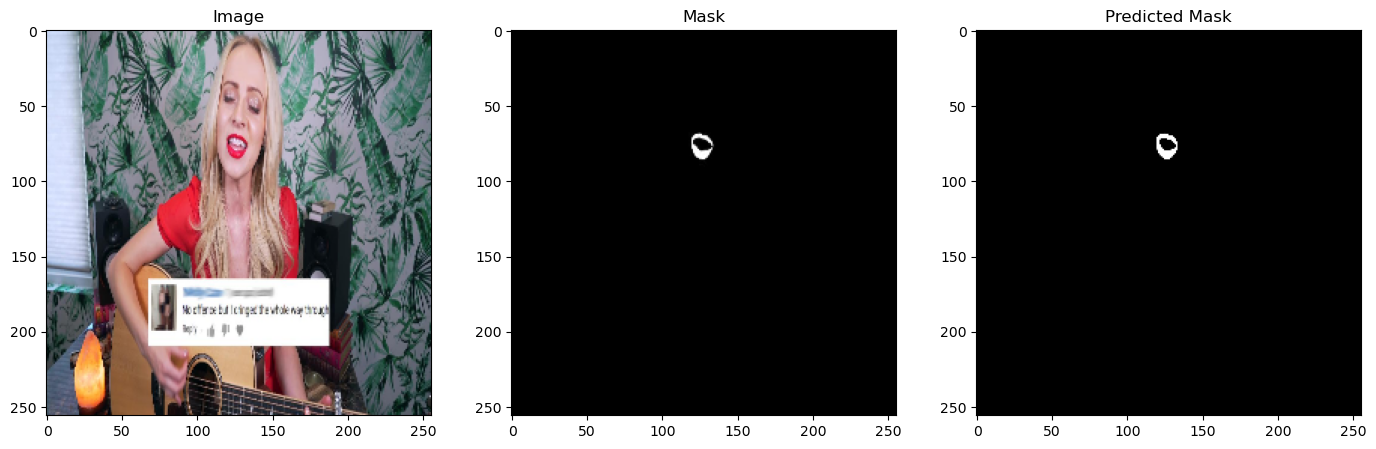


duration: 510s (816ms/step)

Training is finished!


In [22]:
history = model_training(segmodel, 
                         criterion, 
                         optimizer, 
                         epochs=10, 
                         device=device, 
                         train_set=train_loader, 
                         valid_set=test_loader)

In [23]:
indices = np.random.randint(len(test_dataset), size=10)

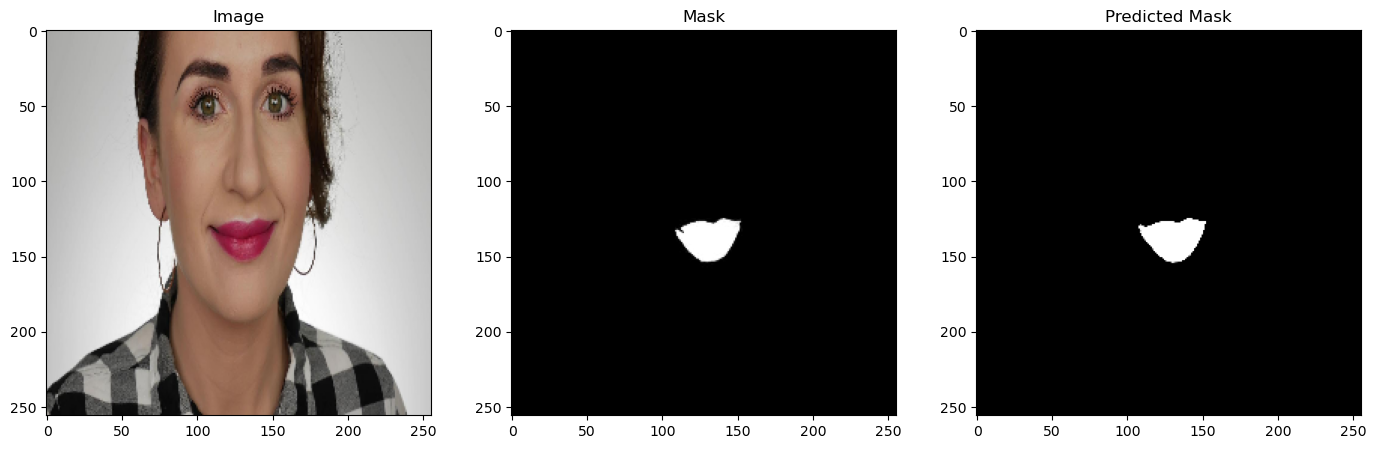

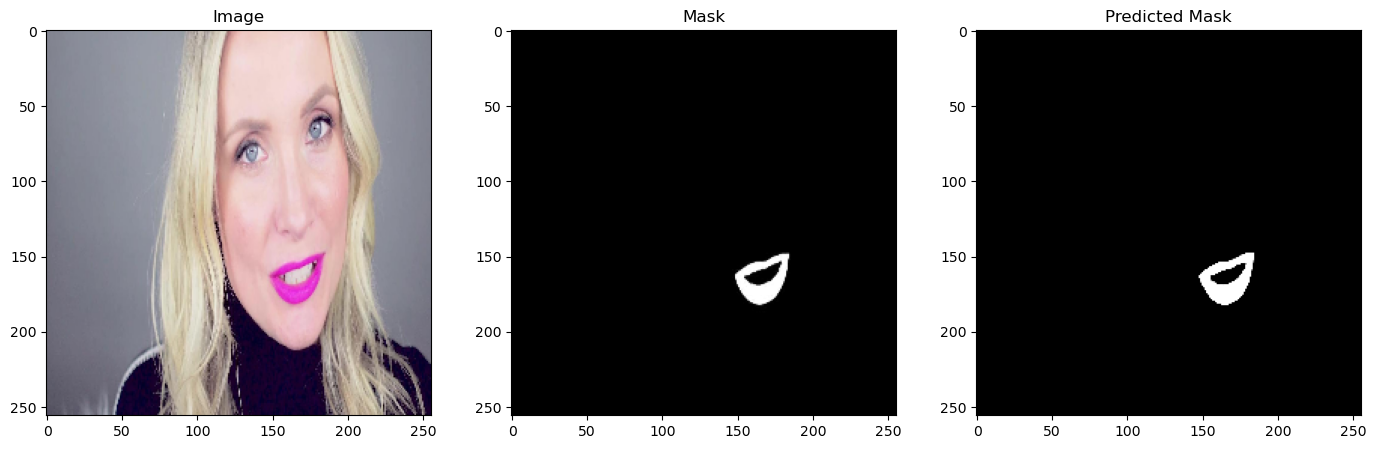

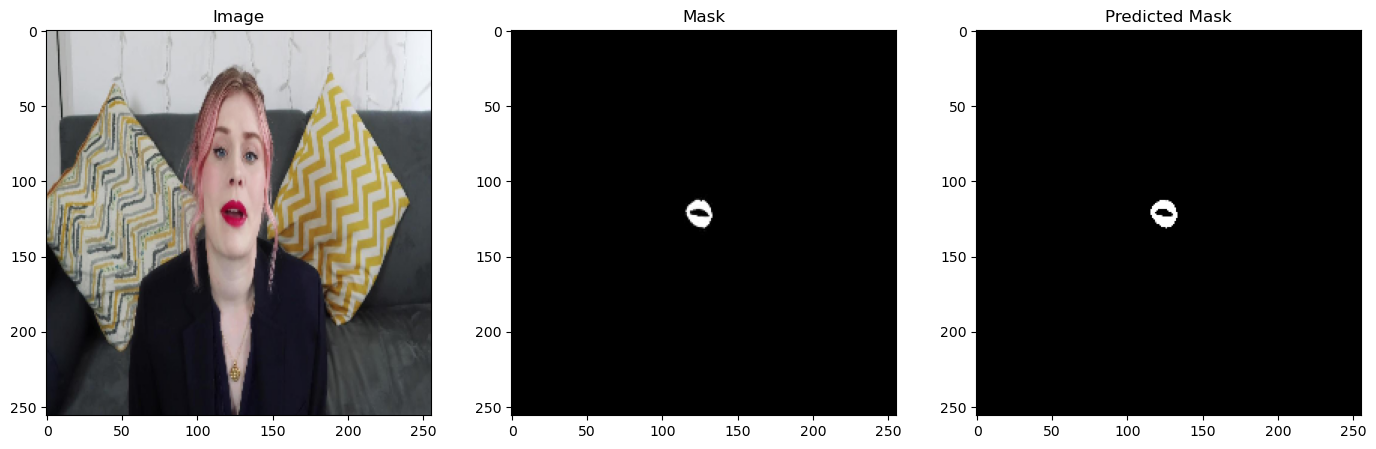

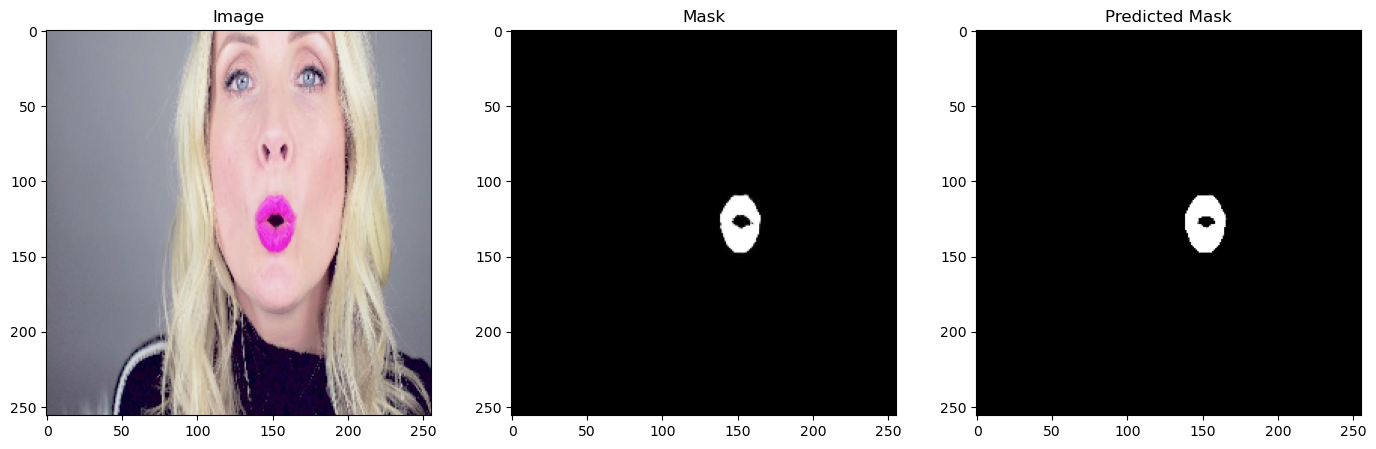

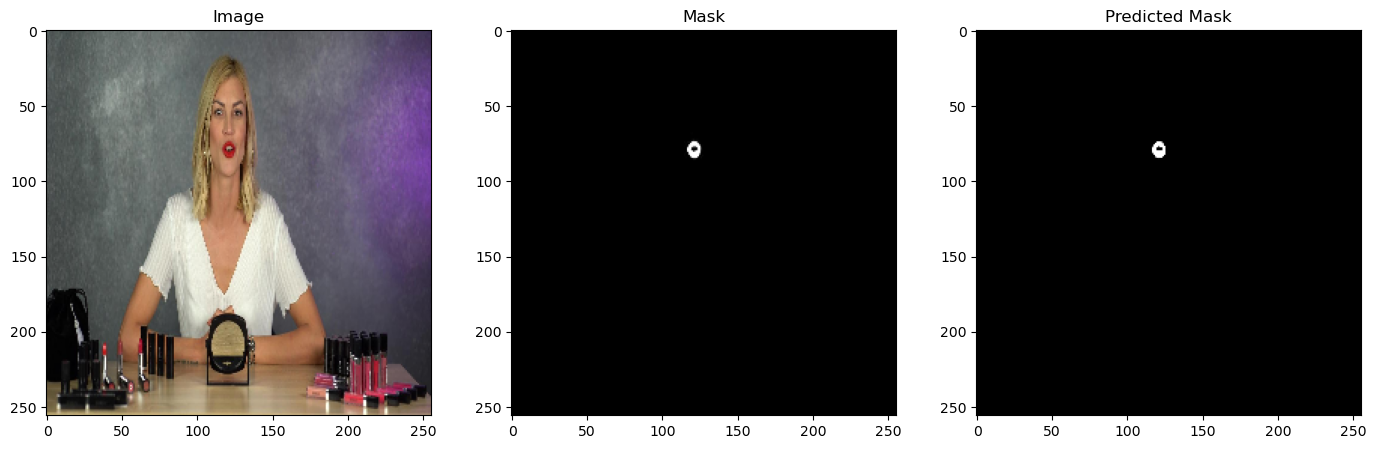

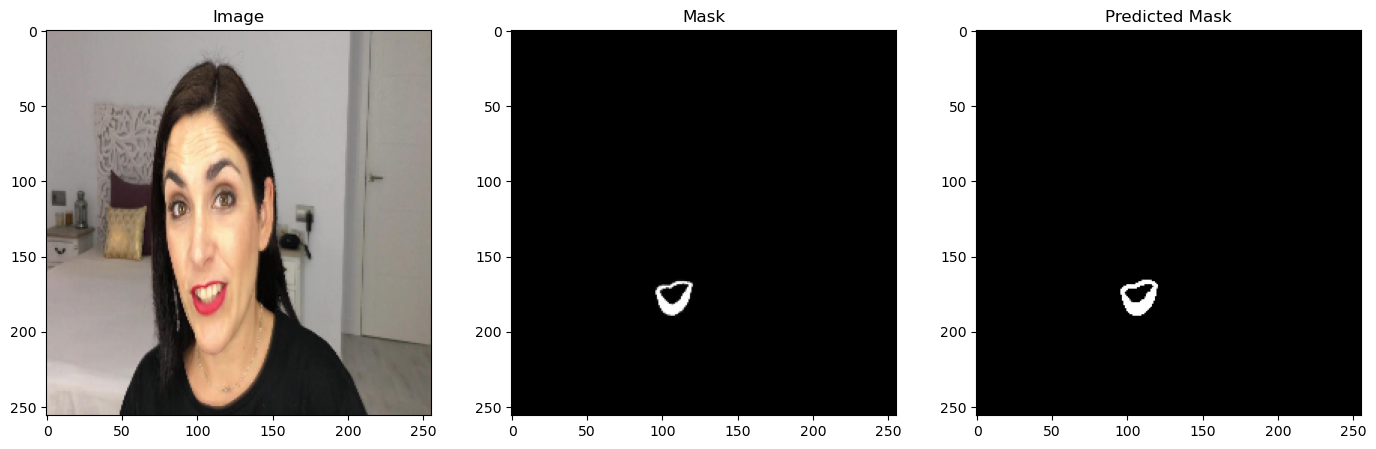

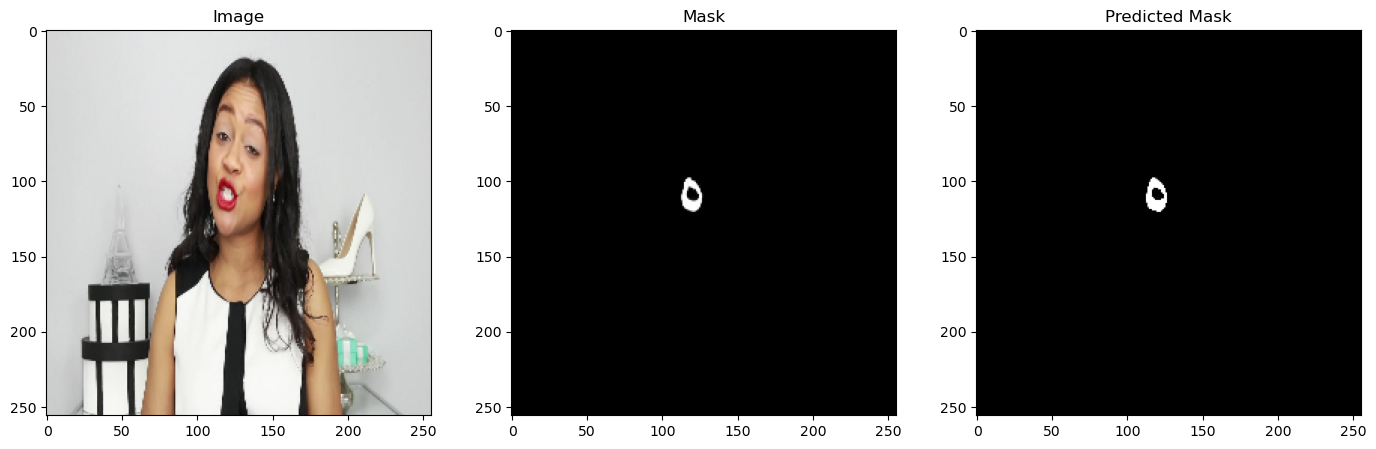

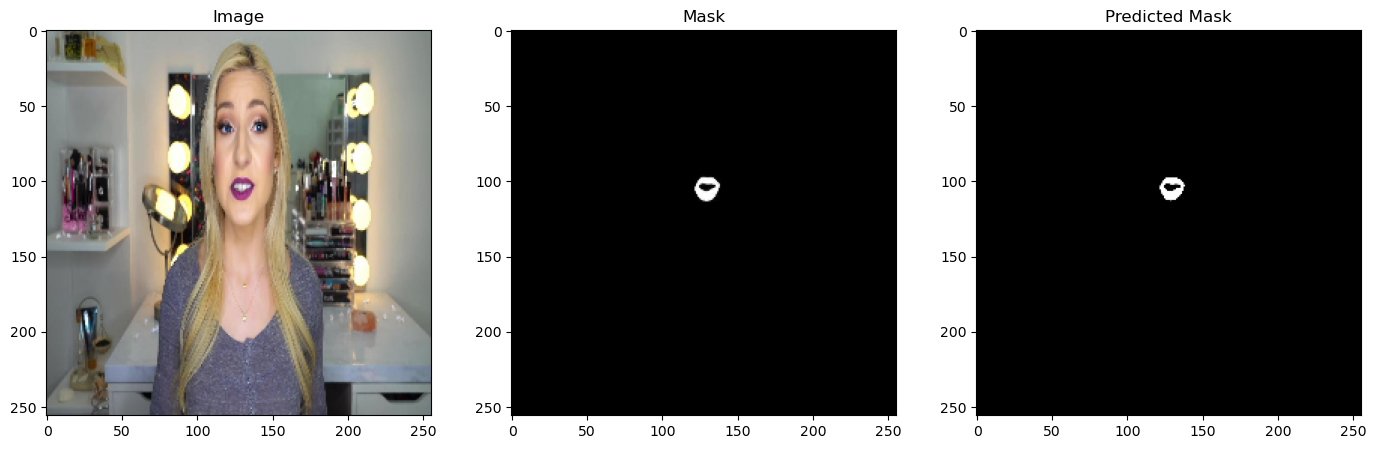

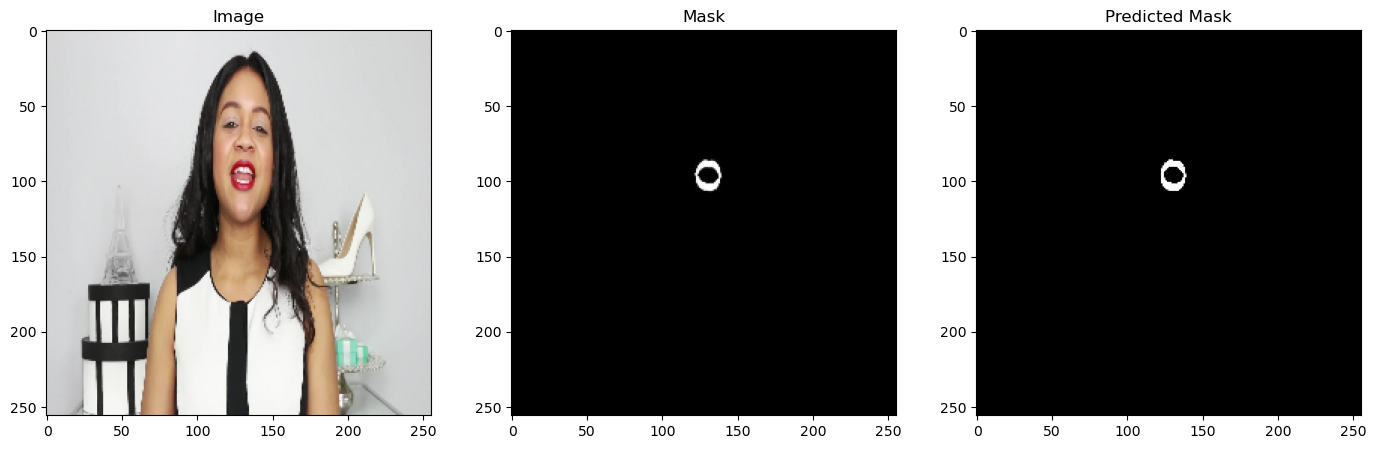

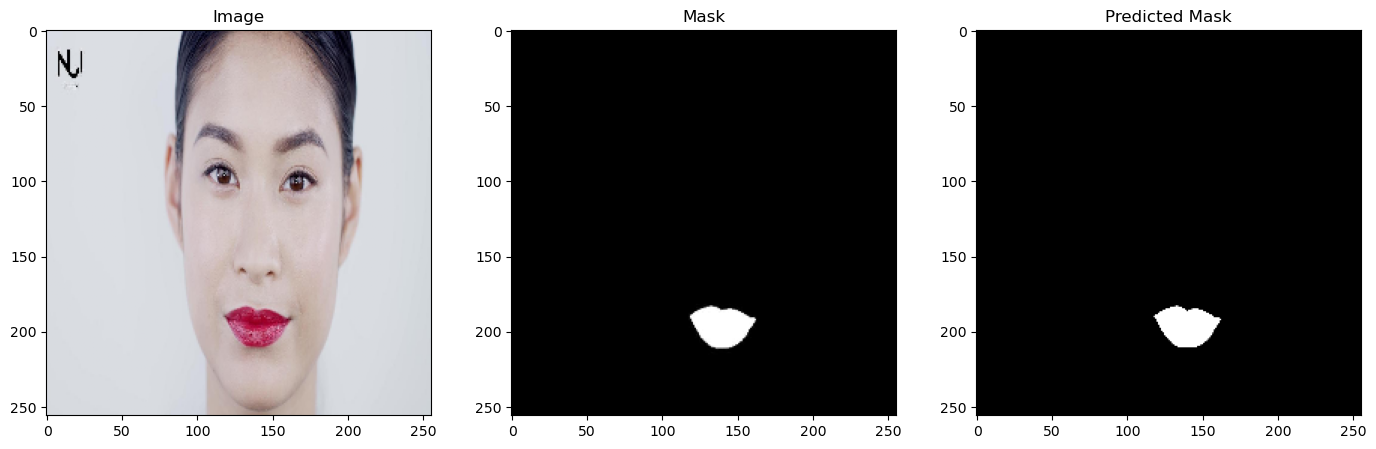

In [25]:
segmodel.eval()
with torch.no_grad():
    for idx in indices:
        img, mask = test_dataset[idx]
        pred_mask = segmodel(img[np.newaxis, :, :, :].to(device))

        draw_imgs(img, mask, pred_mask[0, ...])